<a href="https://colab.research.google.com/github/adindariztia/Bangkit_DiabetesPredictionML/blob/Alita/PIMA_Dataset_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

Read The Dataset

In [0]:
df = pd.read_csv('diabetes.csv')

Get a Glimpse on dataset

In [6]:
df.shape

(768, 9)

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


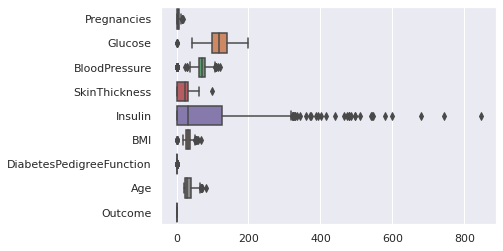

In [9]:
# View data distributions
sns.set()
sns.boxplot(data=df, orient='h')

In [0]:
df.Outcome.mean() #checking the distribution of Outcome, result: 35% in this dataset has Diabetes

0.3489583333333333

In [10]:
# Impute NaNs with median / mean
def fillna_median (col, df):
    df[col].fillna(df[col].median(), inplace = True)
    
def fillna_mean (col, df):
    df[col].fillna(df[col].mean(), inplace = True)

# Impute columns with outliers by median
fillna_median ('BloodPressure', df)
fillna_median ('SkinThickness', df)
fillna_median ('Insulin', df)
fillna_median ('BMI', df)

# Impute columns without outliers by mean
fillna_mean('Glucose', df)

df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Create Correlation Matrix to Know Correlating Features

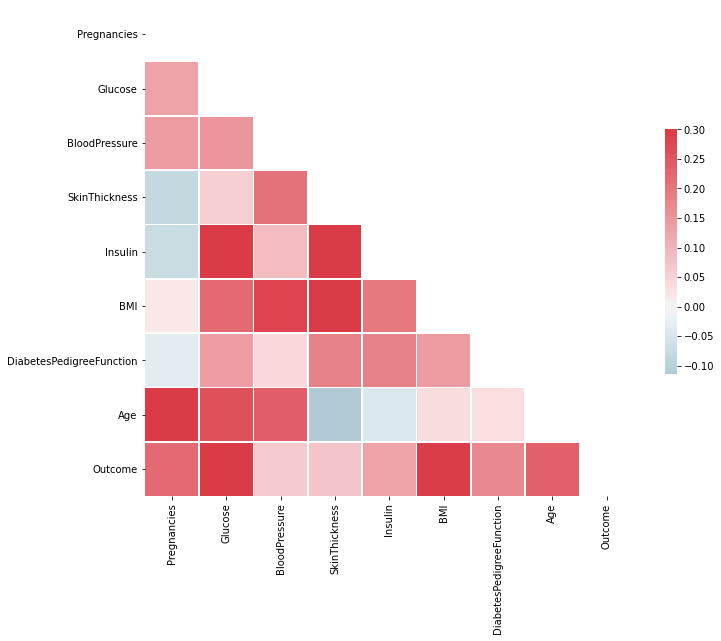

In [0]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Split dataset into train and test set

In [0]:
X = df
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle = True)

In [0]:
# Create an empty list that will eventually hold all created feature columns.
dataset_columns = X.columns
feature_columns = []

# Create numerical feature columns to represent all columns in X
for col in ['Glucose', 'BMI', 'Age', 'Pregnancies']: #Excluding outcome value, since outcome is still included in dataset
    col_tf = tf.feature_column.numeric_column(col)
    feature_columns.append(col_tf)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(X_train))

<tf.Tensor: shape=(691, 4), dtype=float32, numpy=
array([[ 39. ,  24.7,  96. ,   3. ],
       [ 22. ,  30.8, 117. ,   0. ],
       [ 30. ,  37.6, 110. ,   4. ],
       ...,
       [ 38. ,  45.6, 101. ,  10. ],
       [ 29. ,  42.4, 141. ,   0. ],
       [ 21. ,  22.5, 125. ,   0. ]], dtype=float32)>

In [0]:
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


In [0]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/300
70/70 [==============================] - 0s 1ms/step - loss: 50.0945 - accuracy: 0.5528 - precision: 0.3741 - recall: 0.4191
Epoch 2/300
70/70 [==============================] - 0s 1ms/step - loss: 39.6591 - accuracy: 0.5774 - precision: 0.4073 - recall: 0.4647
Epoch 3/300
70/70 [==============================] - 0s 1ms/step - loss: 43.4205 - accuracy: 0.5528 - precision: 0.3731 - recall: 0.4149
Epoch 4/300
70/70 [==============================] - 0s 1ms/step - loss: 40.0820 - accuracy: 0.5615 - precision: 0.3817 - recall: 0.4149
Epoch 5/300
70/70 [==============================] - 0s 1ms/step - loss: 44.4054 - accuracy: 0.5543 - precision: 0.3736 - recall: 0.4108
Epoch 6/300
70/70 [==============================] - 0s 1ms/step - loss: 45.2600 - accuracy: 0.5398 - precision: 0.3536 - recall: 0.3859
Epoch 7/300
70/70 [==============================] - 0s 1ms/step - loss: 40.9631 - accuracy: 0.5673 - precision: 0.3926 - recall: 0.4398
Epoch 8/300
70/70 [======================

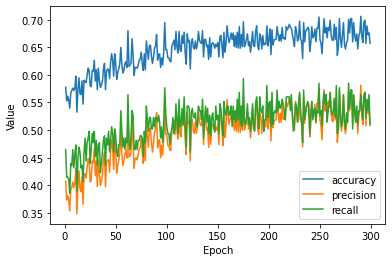

In [0]:
# The following variables are the hyperparameters.
learning_rate = 1
epochs = 300
batch_size = 10
label_name = "Outcome"
classification_threshold = 0.5

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
           tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
           tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall' 
                                 ),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, X_train, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)